In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet101V2, DenseNet201
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [2]:
dataset_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'

In [34]:
classes = os.listdir(dataset_path)  
selected_images = []
for _ in range(12):
    random_class = random.choice(classes)  
    class_path = os.path.join(dataset_path, random_class)
    random_image = random.choice(os.listdir(class_path))  
    image_path = os.path.join(class_path, random_image)
    selected_images.append(image_path)

plt.figure(figsize=(15, 10))  
for i, image_path in enumerate(selected_images):
    plt.subplot(3, 4, i+1) 
    img = imread(image_path)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(image_path)))  
    plt.axis('off') 

plt.tight_layout()  
plt.show()

In [33]:
num_classes = len(os.listdir(dataset_path))
print(f"Number of class: {num_classes}")

Number of class: 10


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20  
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


In [6]:
train_gen.class_indices

{'battery': 0,
 'biological': 1,
 'cardboard': 2,
 'clothes': 3,
 'glass': 4,
 'metal': 5,
 'paper': 6,
 'plastic': 7,
 'shoes': 8,
 'trash': 9}

In [12]:
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)  

predictions = Dense(10, activation='softmax')(x) 
model_Resnet= Model(inputs=base_model.input, outputs=predictions)

model_Resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 42,890,122 (163.61 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [13]:
optimizer = optimizers.AdamW(learning_rate=1e-4)  # Higher learning rate

model_Resnet.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
history_Resnet = model_Resnet.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 90s 77ms/step - accuracy: 0.7567 - loss: 0.7837 - val_accuracy: 0.8931 - val_loss: 0.3043
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.9333 - loss: 0.2132 - val_accuracy: 0.9142 - val_loss: 0.2555
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.9535 - loss: 0.1488 - val_accuracy: 0.9195 - val_loss: 0.2393
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.9681 - loss: 0.1124 - val_accuracy: 0.9271 - val_loss: 0.2267
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.9782 - loss: 0.0864 - val_accuracy: 0.9230 - val_loss: 0.2343


In [14]:
results_Resnet = model_Resnet.evaluate(test_generator)
print(f"CNN Test Accuracy: {results_Resnet[1]*100:.2f}%")

247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9194 - loss: 0.2482
CNN Test Accuracy: 92.30%


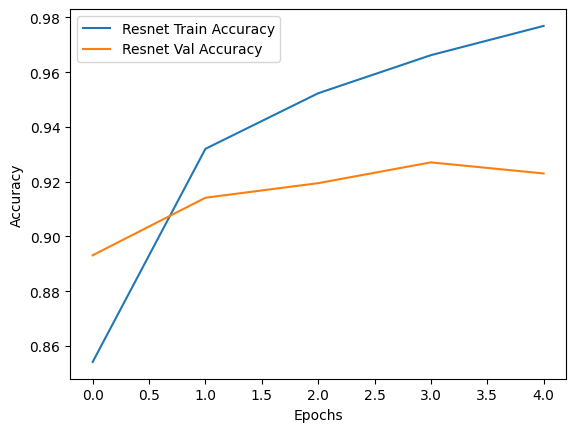

In [15]:
plt.plot(history_Resnet.history['accuracy'], label='Resnet Train Accuracy')
plt.plot(history_Resnet.history['val_accuracy'], label='Resnet Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step


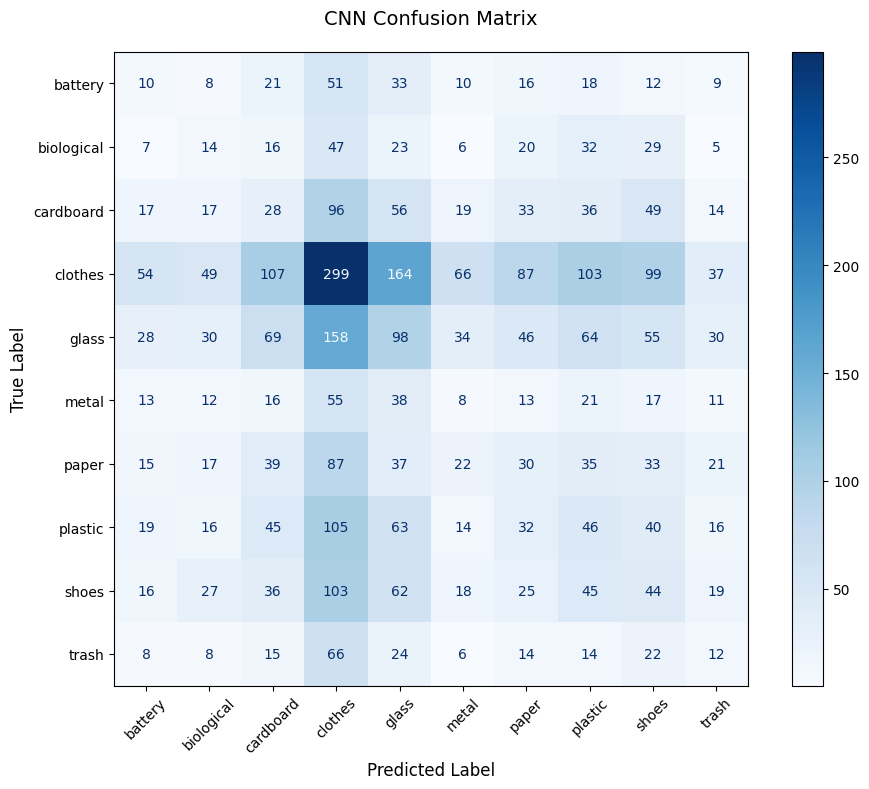

In [16]:
y_pred_cnn = model_Resnet.predict(test_generator)
y_true = test_generator.classes
cm_cnn = confusion_matrix(y_true, np.argmax(y_pred_cnn, axis=1))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=list(test_generator.class_indices.keys())  
)

fig, ax = plt.subplots(figsize=(10, 8))  
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45) 
plt.title('CNN Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.tight_layout() 
plt.show()

In [18]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True

model_Resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_Resnet = model_Resnet.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 101s 83ms/step - accuracy: 0.9277 - loss: 0.2179 - val_accuracy: 0.9400 - val_loss: 0.1930
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.9877 - loss: 0.0463 - val_accuracy: 0.9428 - val_loss: 0.2134
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - accuracy: 0.9926 - loss: 0.0262 - val_accuracy: 0.9415 - val_loss: 0.2130
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9957 - loss: 0.0170 - val_accuracy: 0.9377 - val_loss: 0.2554
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.9890 - loss: 0.0312 - val_accuracy: 0.9395 - val_loss: 0.2557


In [19]:
results_Resnet = model_Resnet.evaluate(test_generator)
print(f"CNN Test Accuracy: {results_Resnet[1]*100:.2f}%")

247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9297 - loss: 0.2903
CNN Test Accuracy: 93.95%


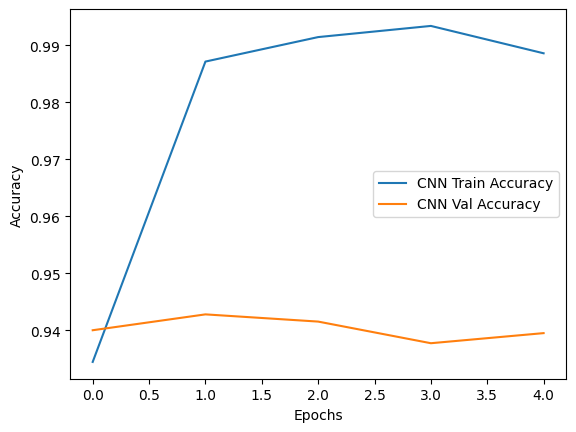

In [20]:
plt.plot(history_Resnet.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_Resnet.history['val_accuracy'], label='CNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step


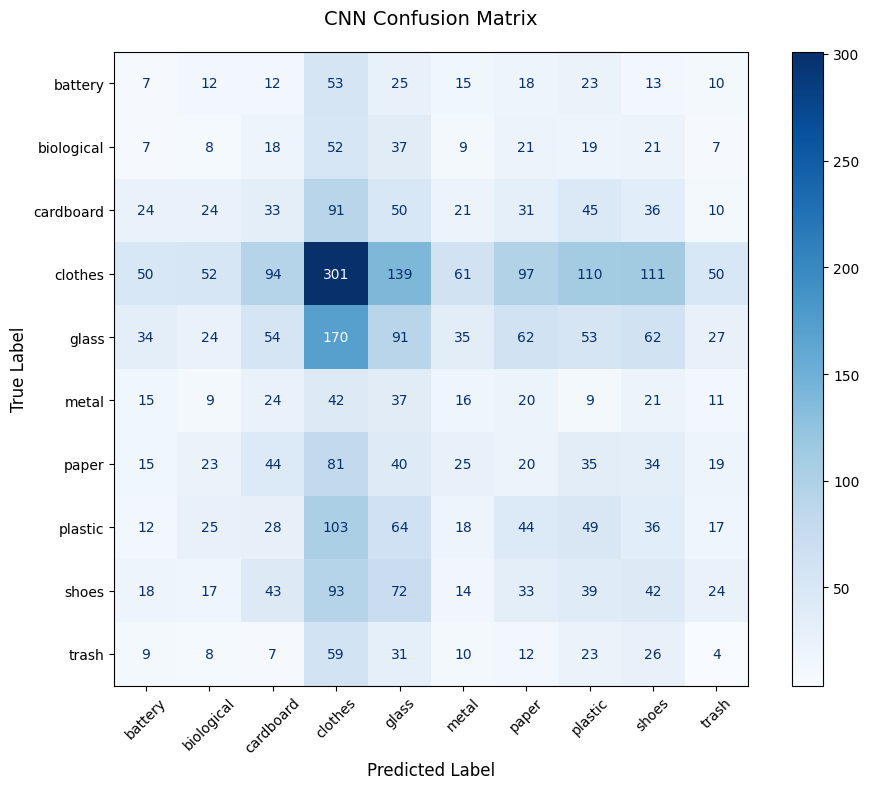

In [21]:
y_pred_cnn = model_Resnet.predict(test_generator)
y_true = test_generator.classes
cm_cnn = confusion_matrix(y_true, np.argmax(y_pred_cnn, axis=1))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=list(test_generator.class_indices.keys())  
)

fig, ax = plt.subplots(figsize=(10, 8)) 
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45) 
plt.title('CNN Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
plt.tight_layout()  
plt.show()

In [35]:
model_Resnet.save('model_Resnet.h5')

---------------
-------------
-------
-----------

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)

model_DenseNet = Model(inputs=base_model.input, outputs=predictions)


model_DenseNet.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_4"

 Non-trainable params: 18,321,984 (69.89 MB)

In [23]:
optimizer = optimizers.AdamW(learning_rate=1e-4)  # Higher learning rate

model_DenseNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

History_DenseNet = model_DenseNet.fit(train_gen, 
                                      epochs=5, 
                                      validation_data=val_gen)

Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 113ms/step - accuracy: 0.7116 - loss: 0.9387 - val_accuracy: 0.9010 - val_loss: 0.3150
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9184 - loss: 0.2637 - val_accuracy: 0.9119 - val_loss: 0.2706
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9381 - loss: 0.2020 - val_accuracy: 0.9250 - val_loss: 0.2415
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.9478 - loss: 0.1668 - val_accuracy: 0.9215 - val_loss: 0.2350
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.9548 - loss: 0.1416 - val_accuracy: 0.9268 - val_loss: 0.2245


In [25]:
results_DenseNet = model_DenseNet.evaluate(test_generator)
print(f"CNN Test Accuracy: {results_DenseNet[1]*100:.2f}%")

247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9310 - loss: 0.2144
CNN Test Accuracy: 92.68%


247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step


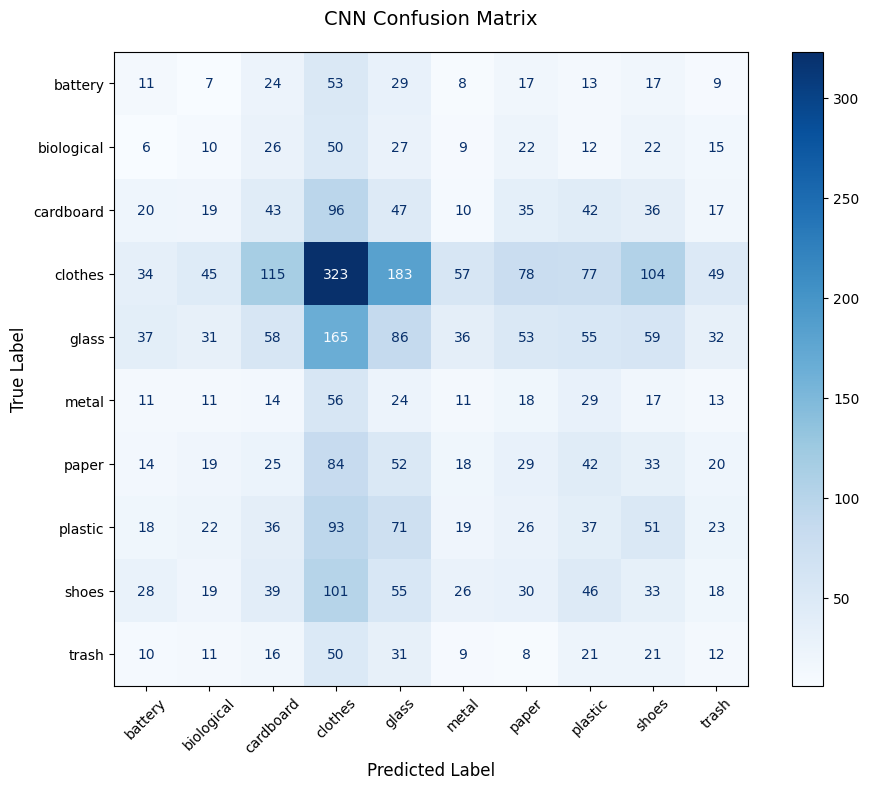

In [26]:
y_pred_cnn = model_DenseNet.predict(test_generator)
y_true = test_generator.classes
cm_cnn = confusion_matrix(y_true, np.argmax(y_pred_cnn, axis=1))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=list(test_generator.class_indices.keys()) 
)

fig, ax = plt.subplots(figsize=(10, 8))  
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)  
plt.title('CNN Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.tight_layout()  
plt.show()

In [27]:
for layer in base_model.layers[-20:]: 
    layer.trainable = True

model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

History_DenseNet = model_DenseNet.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 147s 112ms/step - accuracy: 0.9402 - loss: 0.1850 - val_accuracy: 0.9301 - val_loss: 0.2174
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - accuracy: 0.9571 - loss: 0.1394 - val_accuracy: 0.9392 - val_loss: 0.1924
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.9719 - loss: 0.0927 - val_accuracy: 0.9400 - val_loss: 0.1975
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - accuracy: 0.9840 - loss: 0.0585 - val_accuracy: 0.9410 - val_loss: 0.1981
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.9898 - loss: 0.0402 - val_accuracy: 0.9461 - val_loss: 0.1917


In [28]:
results_DenseNet = model_DenseNet.evaluate(test_generator)
print(f"CNN Test Accuracy: {results_DenseNet[1]*100:.2f}%")

247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9463 - loss: 0.1808
CNN Test Accuracy: 94.61%


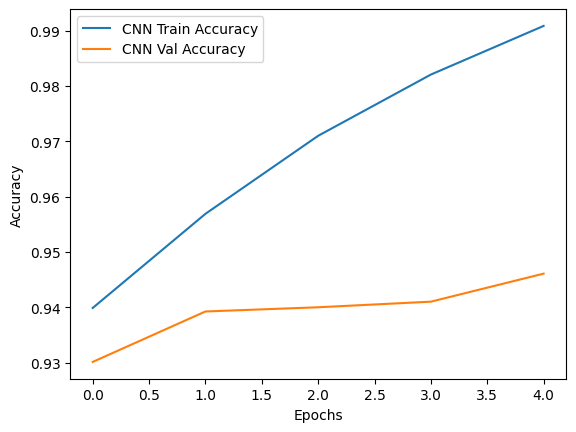

In [29]:
plt.plot(History_DenseNet.history['accuracy'], label='CNN Train Accuracy')
plt.plot(History_DenseNet.history['val_accuracy'], label='CNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step


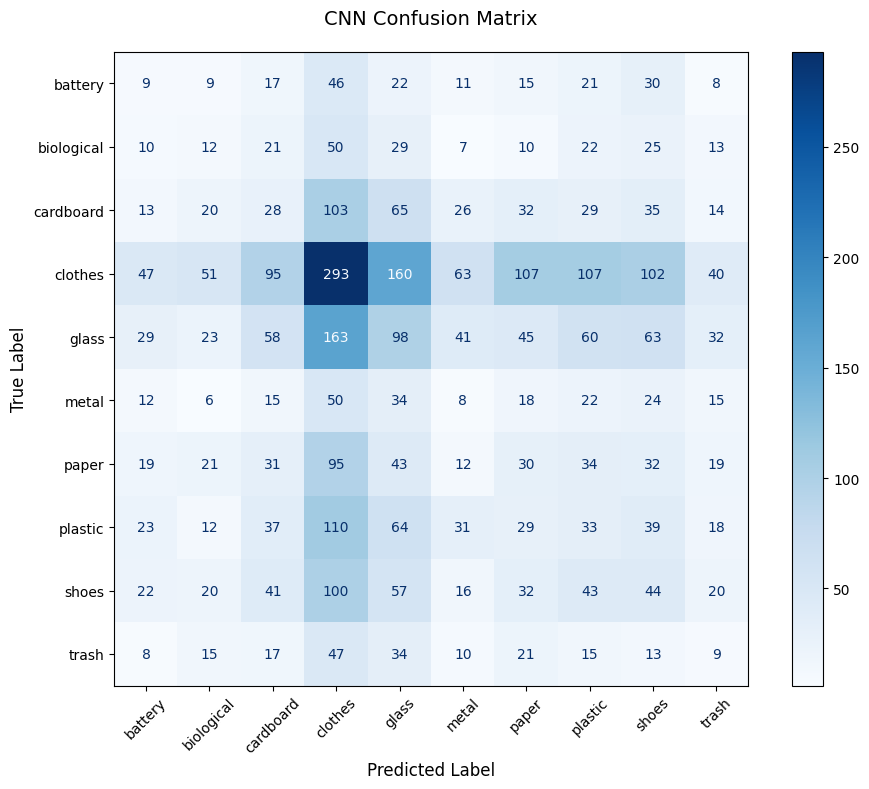

In [30]:
y_pred_cnn = model_DenseNet.predict(test_generator)
y_true = test_generator.classes
cm_cnn = confusion_matrix(y_true, np.argmax(y_pred_cnn, axis=1))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=list(test_generator.class_indices.keys())  
)

fig, ax = plt.subplots(figsize=(10, 8))  
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)  
plt.title('CNN Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)  
plt.tight_layout()  
plt.show()

In [36]:
model_Resnet.save('model_DenseNet.h5')

------------------------
-------
__________
____________